In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Conv1D, GlobalMaxPooling1D, MaxPooling1D
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model

import datetime
import os

Using TensorFlow backend.


In [2]:
### 데이터 로드
#data = pd.read_csv('dataset/ethereum_dataset.csv', index_col=0)
data = pd.read_csv('dataset/PM_2.5_dataset.csv', index_col=0)
data.head()

,PM,temprature,humidity,max wind speed,wind direction
Date,,,,,
2009-01-01,43.739130,-5.8,45.8,4.5,290.0
2009-01-02,45.750000,-2.8,51.5,3.7,230.0
2009-01-03,46.833333,-1.0,48.3,3.9,250.0
2009-01-04,40.083333,0.4,44.3,4.3,290.0
2009-01-05,58.541667,-1.6,53.1,4.5,270.0


In [3]:
## 정규화 함수
def normalize_windows(data):
    normalized_data = []

    for window in data:
        normalized_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalized_data.append(normalized_window)
        
    return np.array(normalized_data)

In [4]:
### 데이터 전처리
pm_data = data['PM'].values

seq_len = 30
sequence_length = seq_len + 1

pm = []
for index in range(len(pm_data) - sequence_length):
    pm.append(pm_data[index: index + sequence_length])
    
norm_pm = normalize_windows(pm)
print(norm_pm[0])

[ 0.          0.04597416  0.07074221 -0.08358184  0.33842777  1.19483101
  0.90047217  0.65088635  0.4917992   0.23649768 -0.05119284  0.20982439
 -0.0273774   0.42702121 -0.11787608  0.22982936  1.15196322  1.48156892
  0.8699884   0.10884692  0.28317594  0.39463221  0.68899105  0.01358516
  0.07360007 -0.2436216   0.04121107  0.04216368  0.34128562 -0.11501822
 -0.50940192]


In [5]:
## temprature data
temprature_data = data['temprature'].values
delta = 1e-7
for i in range(len(temprature_data)):
    if temprature_data[i] == 0:
        temprature_data[i] = temprature_data[i]+delta

temprature = []
for index in range(len(temprature_data) - sequence_length):
    temprature.append(temprature_data[index: index + sequence_length])
    
norm_temprature = normalize_windows(temprature)
print(norm_temprature[0])

[ 0.         -0.51724138 -0.82758621 -1.06896552 -0.72413793 -0.65517241
 -0.9137931  -0.84482759 -0.39655172  0.29310345  0.37931034  0.34482759
 -0.05172414  0.13793103  0.0862069  -0.51724138 -0.75862069 -1.44827586
 -1.10344828 -1.37931034 -1.67241379 -1.62068966  0.55172414  0.39655172
 -0.20689655 -0.43103448 -0.67241379 -1.25862069 -1.56896552 -2.
 -2.05172414]


In [6]:
## humidity data
humidity_data = data['humidity'].values

humidity = []
for index in range(len(humidity_data) - sequence_length):
    humidity.append(humidity_data[index: index + sequence_length])
    
norm_humidity = normalize_windows(humidity)
print(norm_humidity[0])

[ 0.          0.12445415  0.05458515 -0.03275109  0.15938865  0.09170306
 -0.08296943 -0.08296943 -0.06113537 -0.08296943 -0.13755459  0.0371179
 -0.01091703 -0.13537118 -0.2489083   0.76419214  0.6768559   0.56768559
  0.04803493 -0.33842795  0.17030568  0.34497817 -0.15720524  0.37336245
  0.4279476   0.3930131   0.15283843 -0.08078603 -0.19213974  0.01746725
  0.10043668]


In [7]:
## wind data
wind_speed_data = data['max wind speed'].values

wind_speed = []
for index in range(len(wind_speed_data) - sequence_length):
    wind_speed.append(wind_speed_data[index: index + sequence_length])
    
norm_wind_speed = normalize_windows(wind_speed)
print(norm_wind_speed[0])

[ 0.         -0.17777778 -0.13333333 -0.04444444  0.         -0.31111111
 -0.11111111 -0.06666667  0.02222222  0.11111111  0.62222222  0.48888889
 -0.08888889  0.31111111 -0.15555556 -0.28888889 -0.22222222  0.35555556
  0.35555556 -0.26666667  0.08888889  0.8         0.77777778  0.31111111
  0.55555556  0.24444444 -0.13333333 -0.26666667 -0.31111111  0.22222222
  0.02222222]


In [8]:
## wind direction data
wind_direction_data = data['wind direction'].values

wind_direction = []
for index in range(len(wind_direction_data) - sequence_length):
    wind_direction.append(wind_direction_data[index: index + sequence_length])
    
norm_wind_direction = normalize_windows(wind_direction)
print(norm_wind_direction[0])

[ 0.         -0.20689655 -0.13793103  0.         -0.06896552  0.
  0.          0.          0.         -0.06896552  0.         -0.06896552
  0.          0.         -0.13793103 -0.82758621 -0.82758621 -0.06896552
 -0.06896552  0.         -0.31034483 -0.06896552  0.         -0.13793103
 -0.13793103 -0.06896552 -0.13793103 -0.75862069 -0.06896552 -0.75862069
 -0.82758621]


In [9]:
def marge_data(a, b, c, d, e):
    marged_data = []
    marge = []
    
    for a_index, b_index, c_index, d_index, e_index in zip(a, b, c, d, e):
        for i in range(len(a_index)):
            marge.append(a_index[i])
            marge.append(b_index[i])
            marge.append(c_index[i])
            marge.append(d_index[i])
            marge.append(e_index[i])
        
        for i in range(4):
            marge.pop()
        
        marged_data.append(marge)
        marge = []
    
    return np.array(marged_data)

norm_result = marge_data(norm_pm, norm_temprature, norm_humidity, norm_wind_speed, norm_wind_direction)
print(norm_result[0])

[ 0.          0.          0.          0.          0.          0.04597416
 -0.51724138  0.12445415 -0.17777778 -0.20689655  0.07074221 -0.82758621
  0.05458515 -0.13333333 -0.13793103 -0.08358184 -1.06896552 -0.03275109
 -0.04444444  0.          0.33842777 -0.72413793  0.15938865  0.
 -0.06896552  1.19483101 -0.65517241  0.09170306 -0.31111111  0.
  0.90047217 -0.9137931  -0.08296943 -0.11111111  0.          0.65088635
 -0.84482759 -0.08296943 -0.06666667  0.          0.4917992  -0.39655172
 -0.06113537  0.02222222  0.          0.23649768  0.29310345 -0.08296943
  0.11111111 -0.06896552 -0.05119284  0.37931034 -0.13755459  0.62222222
  0.          0.20982439  0.34482759  0.0371179   0.48888889 -0.06896552
 -0.0273774  -0.05172414 -0.01091703 -0.08888889  0.          0.42702121
  0.13793103 -0.13537118  0.31111111  0.         -0.11787608  0.0862069
 -0.2489083  -0.15555556 -0.13793103  0.22982936 -0.51724138  0.76419214
 -0.28888889 -0.82758621  1.15196322 -0.75862069  0.6768559  -0.2222

In [10]:
# train_cut = -90 # 마지막 3달의 데이터를 test데이터로 한다
train_cut = int(round(norm_result.shape[0] * 0.7))

valid_cut = -365
        
train = norm_result[:train_cut, :]
np.random.shuffle(train)

valid = norm_result[train_cut:valid_cut, :]

test = norm_result[valid_cut:, :]

x_train = train[:, :-1]
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
y_train = train[:,-1]
y_train = np.reshape(y_train, (y_train.shape[0], 1))

x_valid = valid[:, :-1]
x_valid = np.reshape(x_valid, (x_valid.shape[0], x_valid.shape[1], 1))
y_valid = valid[:,-1]
y_valid = np.reshape(y_valid, (y_valid.shape[0], 1))

x_test = norm_result[valid_cut:, :-1]
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
y_test = norm_result[valid_cut:,-1]
y_test = np.reshape(y_test, (y_test.shape[0], 1))

print(x_train.shape, x_valid.shape, x_test.shape)
print(y_train.shape, y_valid.shape, y_test.shape)

(2535, 150, 1) (721, 150, 1) (365, 150, 1)
(2535, 1) (721, 1) (365, 1)


### 모델 체크포인터 롤백
MODEL_SAVE_FOLBER_PATH = './model/checkpoint/'
if not os.path.exists(MODEL_SAVE_FOLBER_PATH):
    os.mkdir(MODEL_SAVE_FOLBER_PATH)
    
model_path = MODEL_SAVE_FOLBER_PATH + '{epoch:02d}-{val_loss:.4f}.hdf5'

# 체크포인트 생성 코드
cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss',verbose=1, save_best_only=True, mode='auto')

In [11]:
### 학습 모델 로드

# model = load_model('model/pm_prediction_model_achi_5.h5')

In [17]:
### VCRNN 모델 설계
model = Sequential()

# model.add(Conv1D(90, 3, activation='relu',strides=3, input_shape=(90,1)))
# model.add(Conv1D(60, 3, activation='relu',strides=3))

model.add(Conv1D(150, 5, activation='relu',strides=5, input_shape=(150,1)))
#model.add(Conv1D(80, 5, activation='relu',strides=1, padding="same"))
#model.add(Conv1D(50, 5, activation='relu',strides=1, padding="same"))
model.add(Conv1D(75, 3, activation='relu',strides=1, padding="same"))

# model.add(Conv1D(90, 3, activation='relu',strides=3, input_shape=(90,1)))
# model.add(Conv1D(60, 7, activation='relu',strides=1, padding="same"))

for i in range (3):
    model.add(LSTM(30, return_sequences=True))   

model.add(LSTM(30, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 30, 150)           900       
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 30, 75)            33825     
_________________________________________________________________
lstm_5 (LSTM)                (None, 30, 30)            12720     
_________________________________________________________________
lstm_6 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
lstm_7 (LSTM)                (None, 30, 30)            7320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
Total para

In [18]:
### 모델 학습
start_time = datetime.datetime.now().strftime('%Y_%m_%d_%H_%M_%S')

model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=30)
# model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=30, batch_size=30, callbacks=[cb_checkpoint])

Train on 2535 samples, validate on 721 samples
Epoch 1/30
2535/2535 [==============================] - 19s 8ms/step - loss: 0.9302 - val_loss: 0.6049
Epoch 2/30
2535/2535 [==============================] - 17s 7ms/step - loss: 0.7902 - val_loss: 0.4626
Epoch 3/30
2535/2535 [==============================] - 17s 7ms/step - loss: 0.7955 - val_loss: 0.4580
Epoch 4/30
2535/2535 [==============================] - 17s 7ms/step - loss: 0.7716 - val_loss: 0.4201
Epoch 5/30
2535/2535 [==============================] - 17s 7ms/step - loss: 0.7664 - val_loss: 0.3893
Epoch 6/30
2535/2535 [==============================] - 16s 7ms/step - loss: 0.7508 - val_loss: 0.6220
Epoch 7/30
2535/2535 [==============================] - 16s 6ms/step - loss: 0.7431 - val_loss: 0.3969
Epoch 8/30
2535/2535 [==============================] - 16s 6ms/step - loss: 0.7268 - val_loss: 0.3924
Epoch 9/30
2535/2535 [==============================] - 16s 7ms/step - loss: 0.7037 - val_loss: 0.4538
Epoch 10/30
2535/2535 [===

In [19]:
## 모델 저장
model. save('model/pm_prediction_model_achi_5.h5')

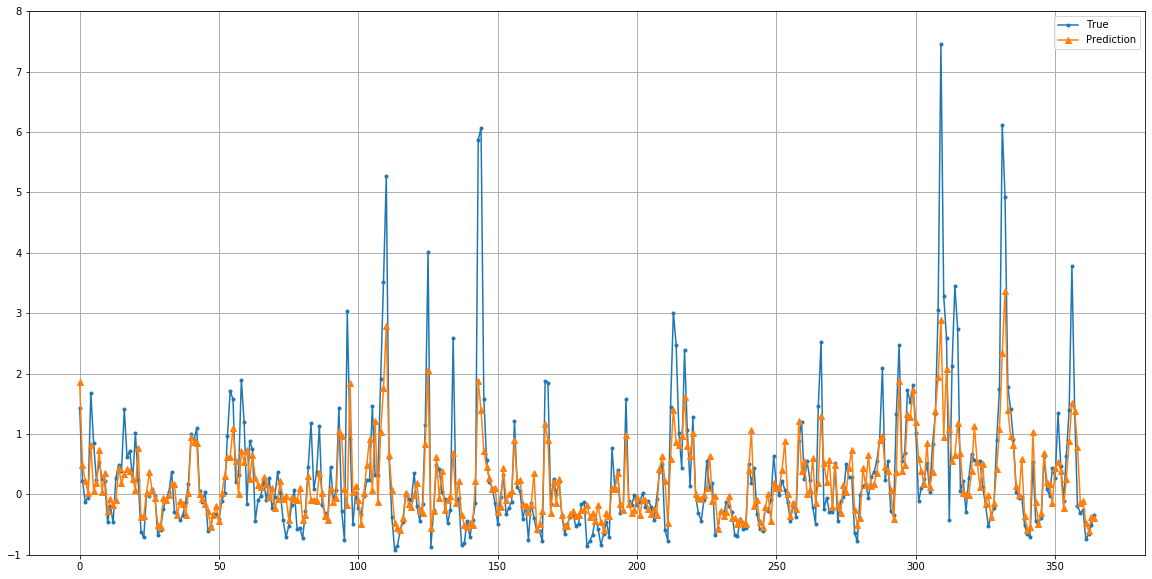

In [20]:
pred = model.predict(x_test)

fig = plt.figure(facecolor='white', figsize=(20, 10))
ax = fig.add_subplot(111)
ax.plot(y_test, label='True', marker='.')
ax.plot(pred, label='Prediction', marker='^')
ax.legend()
ax.grid(linestyle='-', linewidth=1,)
plt.ylim([-1, 8])
plt.show()

In [21]:
pred_error = abs((pred-y_test) / y_test)

total_error_rate = sum(pred_error)/len(pred_error)
print("Total error rate: ", total_error_rate)

Total error rate:  [1.74445482]
